In [1]:
from utils import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from scipy import signal
plt.style.use("light")
import cmasher as cmr

PATH = "/home/max/Temp/Praktikum/experiments-new/"

In [2]:
class GuidewireExperiment:
    def __init__(self, positions):
        self.positions = positions
        self.timesteps = len(self.positions)
        self.n_spheres = len(self.positions["0"]["sphere"])
        self.sphere_pos = self.get_all_spheres()
        self.total_time = self.get_total_time()
        self.elapsed_time = self.get_elapsed_time()
        self.delta = self.get_delta()

    def get_all_spheres(self):
        return np.array([self.get_sphere_position(idx) for idx in range(self.n_spheres)])

    def get_sphere_position(self, idx):
        sphere_pos = np.array(
            [
                np.array(
                    [
                        self.positions[str(i)]["sphere"][str(idx)]["x"],
                        self.positions[str(i)]["sphere"][str(idx)]["y"],
                        self.positions[str(i)]["sphere"][str(idx)]["z"],
                    ]
                )
                for i in range(0, self.timesteps)
            ]
        )
        return sphere_pos  # - sphere_pos[0]

    def get_total_time(self):
        total_time = np.array([self.positions[str(i)]["totalTime"] for i in range(0, self.timesteps)])
        return total_time

    def get_elapsed_time(self):
        elapsed_time = [self.positions["0"]["elapsedMilliseconds"]]
        for i in range(1, self.timesteps):
            elapsed_time.append(elapsed_time[-1] + self.positions[str(i)]["elapsedMilliseconds"])
        # elapsed_time = [self.positions[str(i)]["elapsedMilliseconds"] for i in range(0, self.timesteps)]
        return np.array(elapsed_time)

    def get_delta(self):
        delta = np.array([self.positions[str(i)]["delta"] for i in range(0, self.timesteps)])
        return delta

    def plot_sphere(self, idx, axis=0):
        sphere_pos = self.get_sphere_position(idx)

        plt.figure(figsize=(5, 5), dpi=70)
        plt.plot(sphere_pos[:, axis])
        plt.xlabel("Timestep")
        plt.ylabel("Position [m]")
        plt.show()

    def plot_all_spheres(self, axis=0):
        sphere_matrix = self.sphere_pos[:, :, axis] - self.sphere_pos[:, 0, axis, np.newaxis]
        # sphere_matrix -= np.min(sphere_matrix)

        plt.figure(figsize=(6, 5), dpi=70)
        plt.imshow(sphere_matrix, aspect="auto", cmap="cmr.redshift", extent=[0, self.get_total_time()[-1], 0, self.n_spheres])
        plt.xlabel("In-Game Time [s]")
        plt.ylabel("Sphere Index")
        plt.colorbar(label="Displacement [m]")
        #plt.show()

    def plot_experiment(self, axis=2):

        time_array = self.get_total_time() 
        sphere_pos = self.get_sphere_position(self.n_spheres - 1)

        fig, ax = plt.subplots(3, 1, figsize=(5, 6))

        ax[0].plot(time_array, self.get_elapsed_time() / 1000)
        ax[0].set_title("Total Time")
        ax[0].set_ylabel("Real time [s]")
        ax[0].set_xlabel("In-Game Time [s]")

        ax[1].plot(time_array, sphere_pos[:, axis])
        ax[1].set_title("Last Sphere Displacement")
        ax[1].set_ylabel("Position [m]")
        ax[1].set_xlabel("In-Game Time [s]")

        ax[2].plot(time_array, self.get_delta())
        ax[2].set_title("Simulation Error")
        ax[2].set_ylabel("Error $$\Delta$$ [m]")
        ax[2].set_xlabel("In-Game Time [s]")

        plt.tight_layout()
        #plt.show()


def plot_confidence_interval(x, y, xlabel, ylabel):
    #fig = plt.figure(figsize=(12, 5), dpi=300)
    
    # Get percentiles for the confidence interval
    p10 = np.percentile(y, axis=0, q=[10]).ravel()[:]
    p90 = np.percentile(y, axis=0, q=[90]).ravel()[:]
    p25 = np.percentile(y, axis=0, q=[25]).ravel()[:]
    p75 = np.percentile(y, axis=0, q=[75]).ravel()[:]
    
    # Plot mean and confidence
    plt.fill_between(x, p10, p90, alpha=0.1, color="b", label="$90\%$ CI")
    plt.fill_between(x, p25, p75, alpha=0.25, color="b", label="$75\%$ CI")
    plt.plot(x, np.mean(y, axis=0)[:], "o-", color="black", label="Mean")
    
    # Labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    #return fig

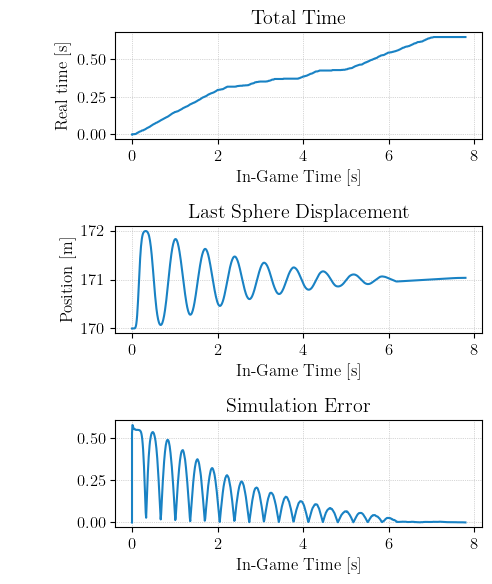

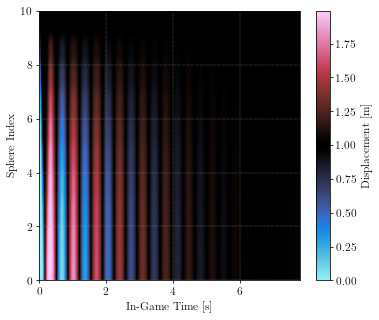

In [3]:
positions = read_json_file("/home/max/Temp/Praktikum/experiments-new/constraint_solver_steps_0/constraint_solver_steps_0_100/positions.json")

experiment1 = GuidewireExperiment(positions)

experiment1.plot_experiment(axis=2)
plt.savefig("/home/max/Nextcloud/Praktikum/Report/figures/experiment1.pdf", bbox_inches="tight", dpi=300)
plt.show()
experiment1.plot_all_spheres(axis=2)
plt.savefig("/home/max/Nextcloud/Praktikum/Report/figures/experiment1_2.pdf", bbox_inches="tight", dpi=300)
plt.show()

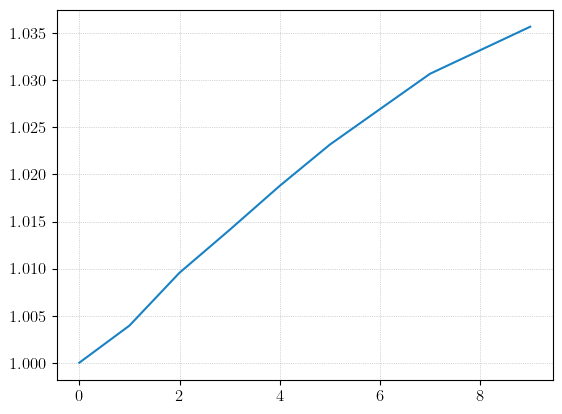

In [4]:
sph = experiment1.get_all_spheres()
sph = sph - sph[:,0,np.newaxis]
plt.plot(sph[:,-1,2])


In [5]:
def func(x, a, b,c):
    return a*np.exp(-x/b)+c

def get_decay_rate(experiment, p0, debug=False):
    xs = experiment.get_total_time()
    #data = experiment.get_sphere_position(experiment.n_spheres-1)[:,2]
    
    sph = experiment.get_all_spheres()
    sph = sph - sph[:,0,np.newaxis]
    data = sph[-1,:,2]# - data[0]
    error = sph[:,-1,2] - 1
    
    # Find the upper peaks of the damped oscillation
    peak_idxs,_ = signal.find_peaks(data)

    peaks_positions = xs[peak_idxs]
    peaks_values = data[peak_idxs]
    
    # Fit exponential decay to the peaks
    popt, pcov = curve_fit(func, peaks_positions, peaks_values, sigma=0.001, p0=p0)

    if debug:
        plt.title(f"Decay rate: {popt[1]:.5f}")
        plt.plot(xs, data, label="Data")
        plt.scatter(xs[peak_idxs], data[peak_idxs], c="red")
        plt.plot(xs, func(xs, *popt), label="Fitted Curve")
        plt.xlabel("In-Game Time [s]")
        plt.ylabel("Displacement [m]")
        plt.show()
        
        plt.plot(error)
        plt.show()
        
    return popt[1],popt[2], error

In [6]:
def get_all_data(name, parameters, debug=False):
    relaxation_times = []
    offsets = []
    loop_times = []
    errors = []
    params_ = []
    
    for run in range(1):
        relaxation_time = []
        offset = []
        loop_time = []
        error_ = []
        param = []
        
        for p in parameters:
            positions = read_json_file(PATH + f"{name}_{run}/{name}_{run}_{p}/positions.json")
            params = read_json_file(PATH + f"{name}_{run}/{name}_{run}_{p}/parameters.json")
            experiment = GuidewireExperiment(positions)
            
            decay_rate, omega, error = get_decay_rate(experiment, debug=debug, p0=[1, 1, params["displacement"]])
            times = experiment.get_total_time()[-1]#np.diff(experiment.get_total_time())
            
            loop_time.append(np.mean(times))
            relaxation_time.append(decay_rate)
            offset.append(omega)
            error_.append(np.sum(np.square(error)))
            param.append(params)
            
        relaxation_times.append(relaxation_time)
        offsets.append(offset)
        loop_times.append(loop_time)
        errors.append(error_)
        params_.append(param)
    return np.array(relaxation_times), np.array(offsets), np.array(loop_times), np.array(errors), params_

def plot_data(x, y, xlabel, ylabel):
    fig = plt.figure(figsize=(4, 3))
    plt.plot(x, y, "o-")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #return fig

In [8]:
constraint_solver_steps = np.arange(100,1100,100)

relaxation_times, offsets, loop_times, errors, params = get_all_data("constraint_solver_steps", constraint_solver_steps)


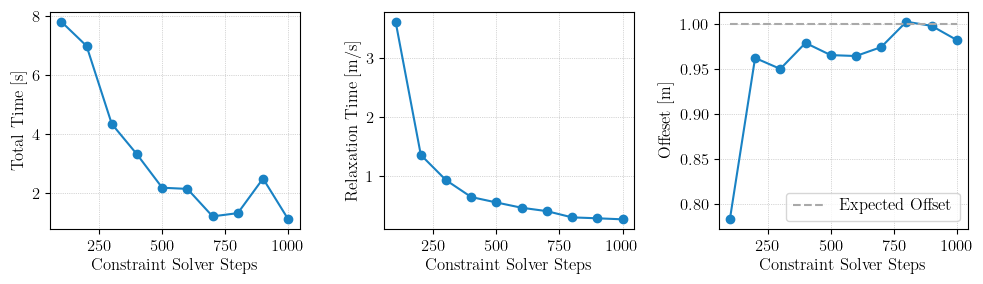

In [9]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

ax[0].plot(constraint_solver_steps, loop_times[0], "o-")
ax[0].set_xlabel("Constraint Solver Steps")
ax[0].set_ylabel("Total Time [s]")

ax[1].plot(constraint_solver_steps, relaxation_times[0], "o-")
ax[1].set_xlabel("Constraint Solver Steps")
ax[1].set_ylabel("Relaxation Time [m/s]")
#ax[1].set_yscale("log")
#ax[1].set_ylim(1e-4, 1e-2)

ax[2].plot(constraint_solver_steps, offsets[0], "o-")
ax[2].set_xlabel("Constraint Solver Steps")
ax[2].set_ylabel("Offeset [m]")
#ax[2].set_yscale("log")
ax[2].hlines(1,100,1000, color="darkgray", linestyle="--", label="Expected Offset")
#ax[2].set_ylim(0.1,1.1)
ax[2].legend()

plt.tight_layout()

plt.savefig("/home/max/Nextcloud/Praktikum/Results/constraint_solver_steps.png", dpi=300, bbox_inches="tight")
plt.show()

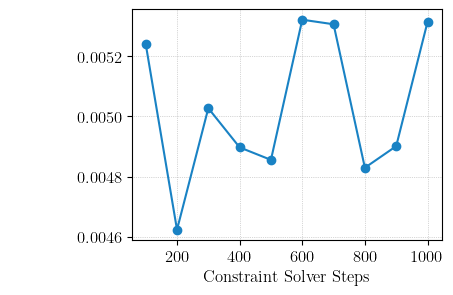

In [10]:
plot_data(constraint_solver_steps, errors[0], "Constraint Solver Steps", "Error $$\Delta$$ [m]")

#plt.savefig("/home/max/Nextcloud/Praktikum/Results/constraint_solver_steps_offset.png", dpi=300, bbox_inches="tight")
plt.show()

# Time steps

In [11]:
timesteps = np.logspace(-4, 0, 10)

relaxation_times, offsets, loop_times, errors, params = get_all_data("time_steps", timesteps, debug=False)

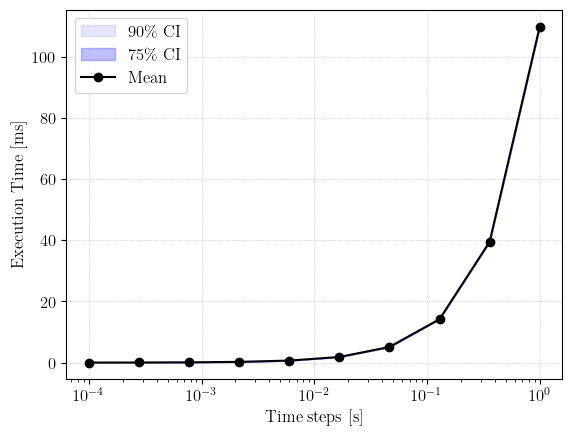

In [12]:
plot_confidence_interval(timesteps, loop_times, "Time steps [s]", "Execution Time [ms]")
plt.xscale("log")
plt.savefig("/home/max/Nextcloud/Praktikum/Results/time_steps_total_time.png", dpi=300, bbox_inches="tight")
plt.show()

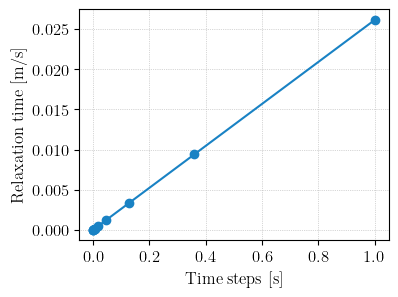

In [13]:
plot_data(timesteps, relaxation_times[0]/1000, "Time steps [s]", "Relaxation time [m/s]")
# plt.xscale("log")
# plt.savefig("/home/max/Nextcloud/Praktikum/Results/time_steps_total_time.png", dpi=300, bbox_inches="tight")
plt.show()

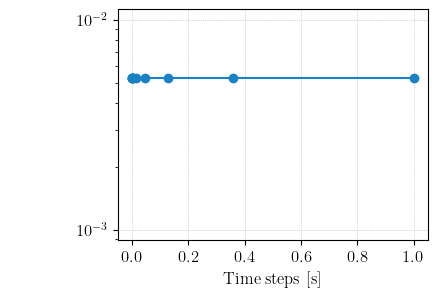

In [14]:
plot_data(timesteps, errors[0], "Time steps [s]", "Error $$\Delta$$ [m]")
plt.yscale("log")
plt.show()

# Rod Element Length

In [15]:

elements = np.arange(5,20,1).astype("float")

relaxation_times, offsets, loop_times, errors, params = get_all_data("rod_elements", elements, debug=False)

/tmp/ipykernel_206421/3927641481.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, peaks_positions, peaks_values, sigma=0.001, p0=p0)


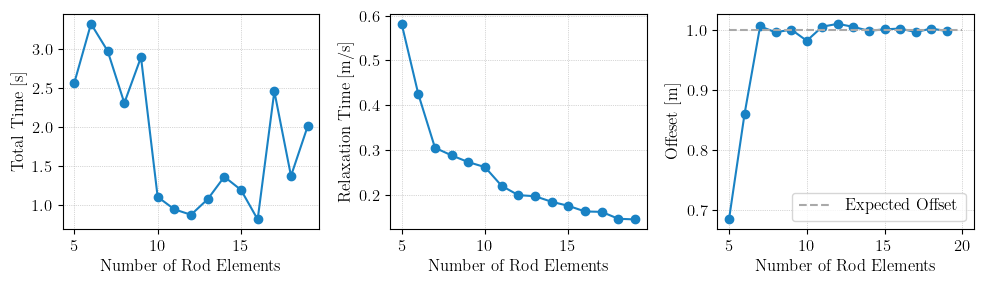

In [20]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

ax[0].plot(elements, loop_times[0], "o-")
ax[0].set_xlabel("Number of Rod Elements")
ax[0].set_ylabel("Total Time [s]")

ax[1].plot(elements, relaxation_times[0], "o-")
ax[1].set_xlabel("Number of Rod Elements")
ax[1].set_ylabel("Relaxation Time [m/s]")
# ax[1].set_yscale("log")
# ax[1].set_ylim(1e-4, 1e-2)

ax[2].plot(elements, offsets[0], "o-")
ax[2].set_xlabel("Number of Rod Elements")
ax[2].set_ylabel("Offeset [m]")
#ax[2].set_yscale("log")
ax[2].hlines(1,5, 20, color="darkgray", linestyle="--", label="Expected Offset")
#ax[2].set_ylim(0.1,1.1)
ax[2].legend()

plt.tight_layout()

plt.savefig("/home/max/Nextcloud/Praktikum/Results/rod_elements.png", dpi=300, bbox_inches="tight")
plt.show()

# Displacement

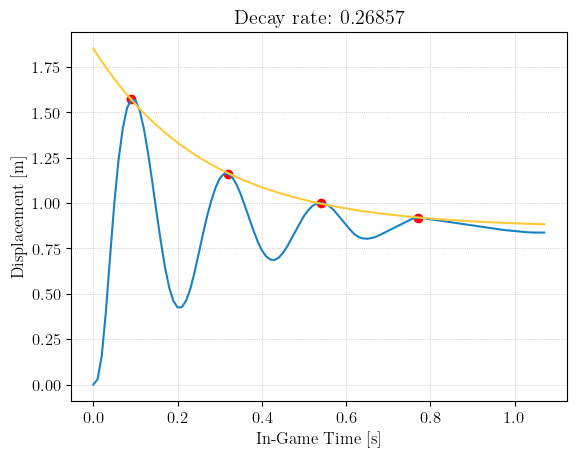

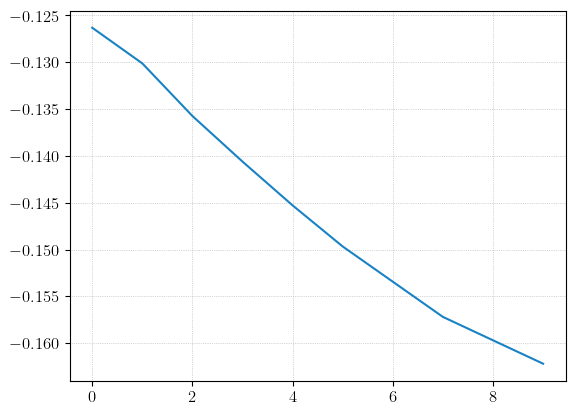

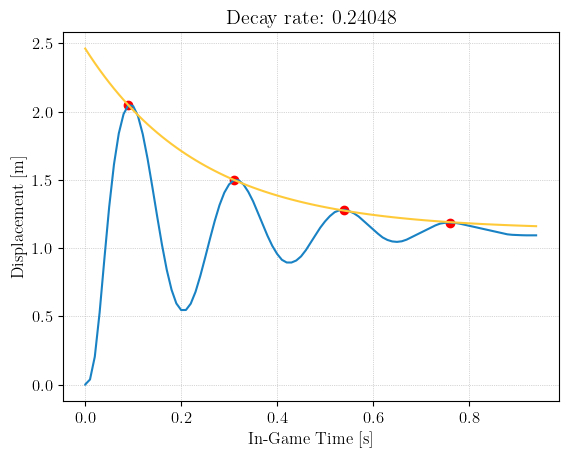

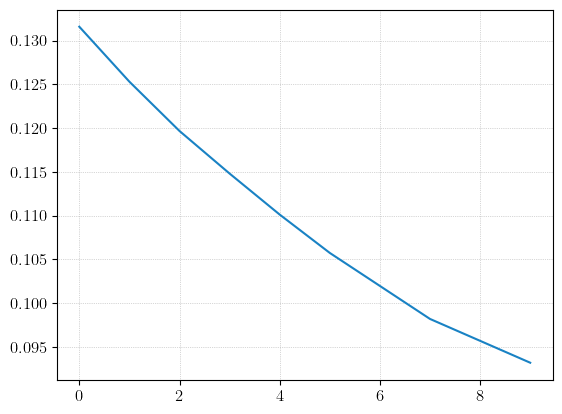

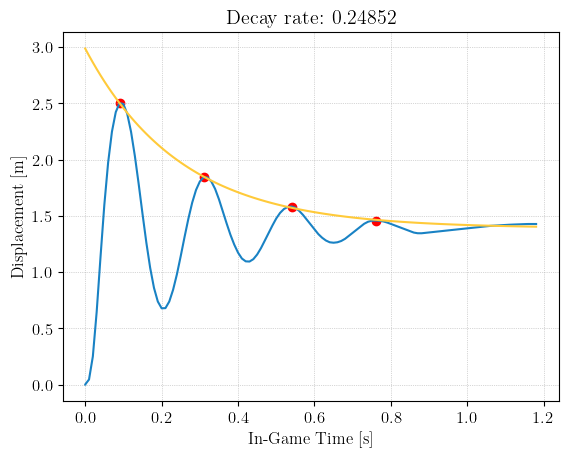

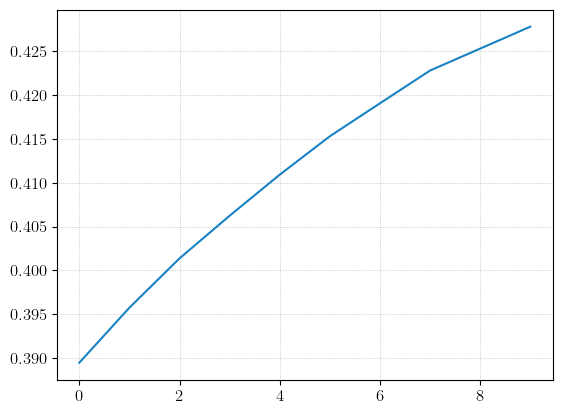

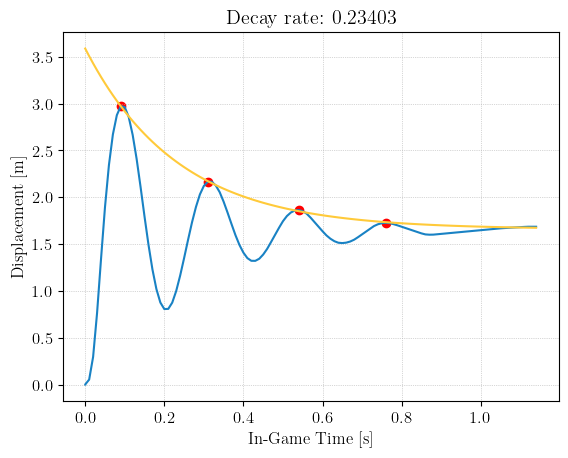

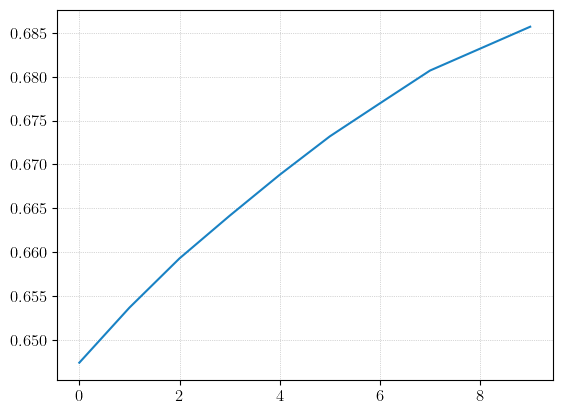

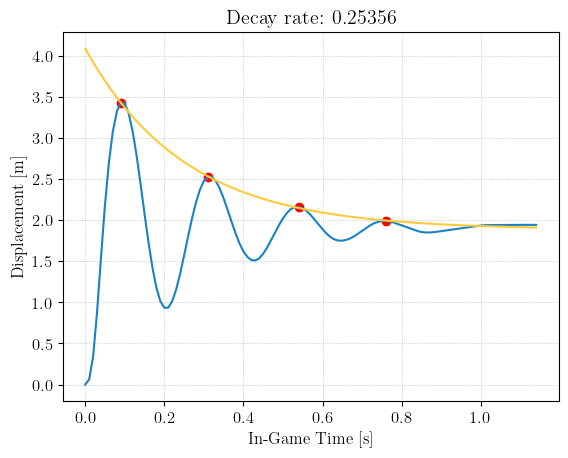

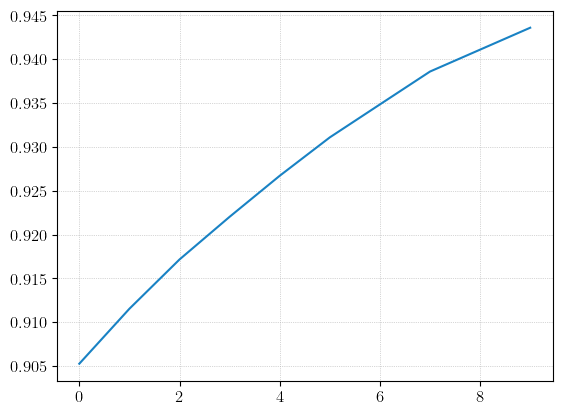

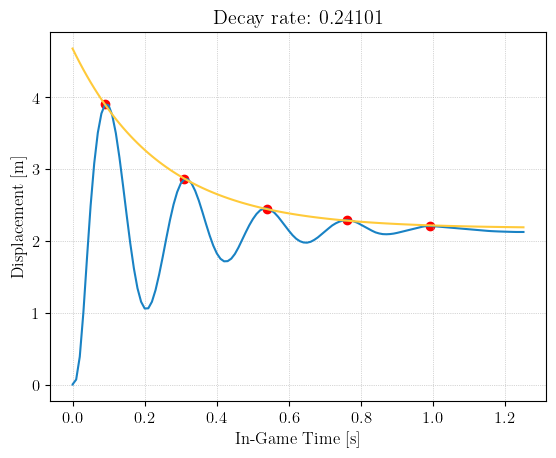

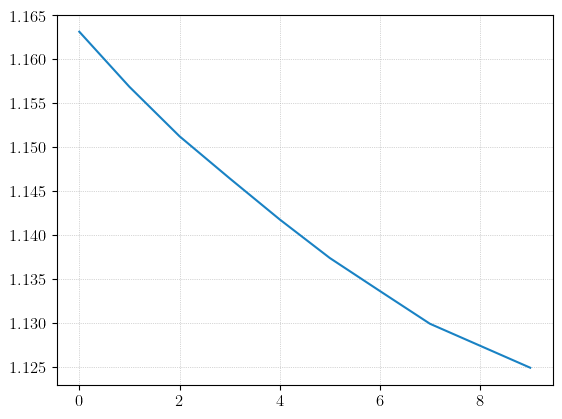

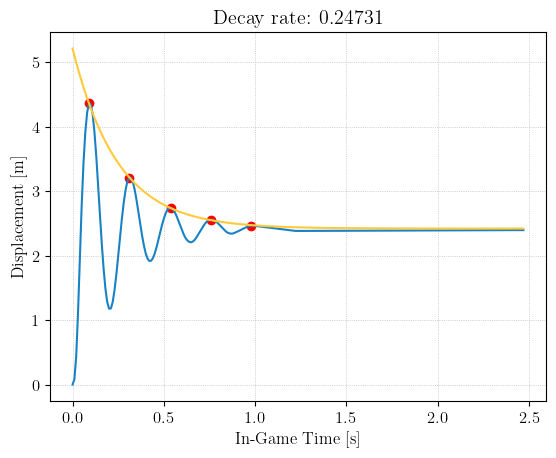

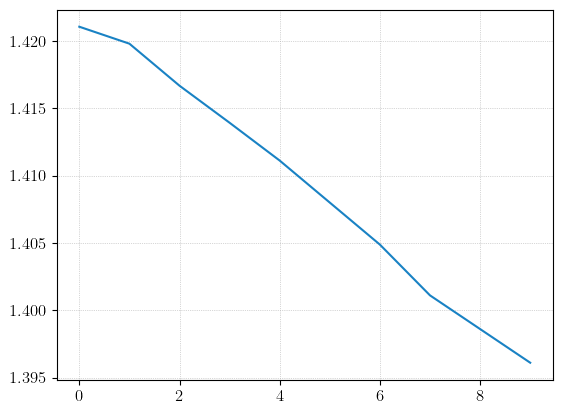

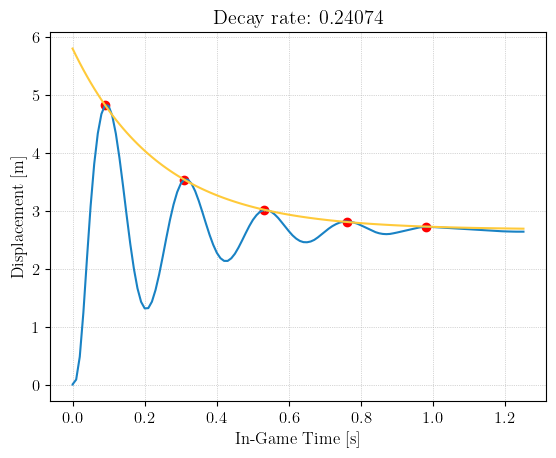

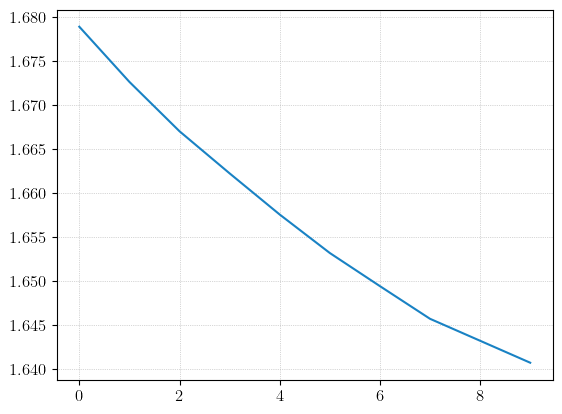

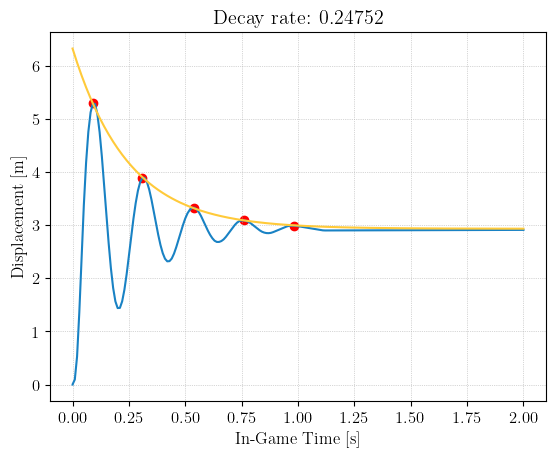

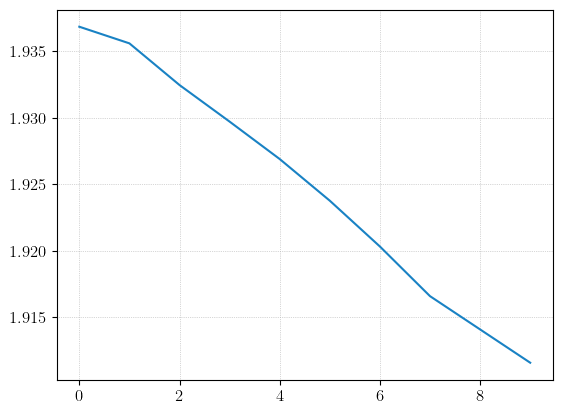

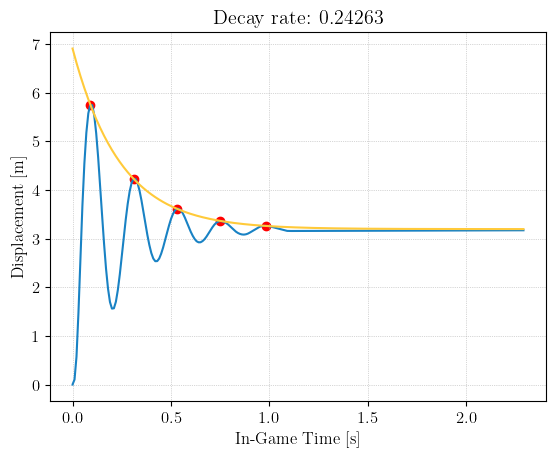

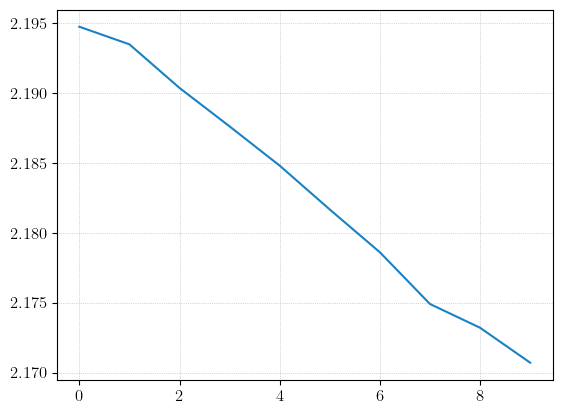

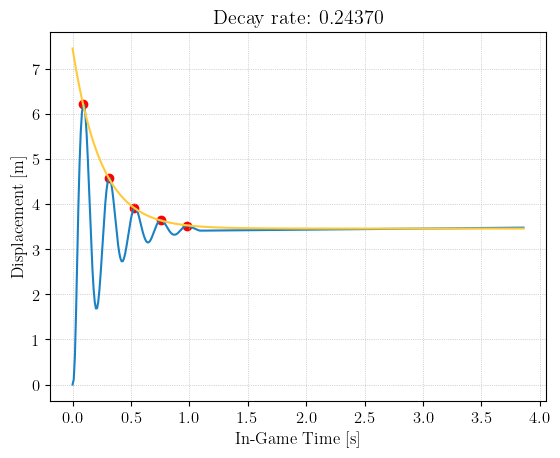

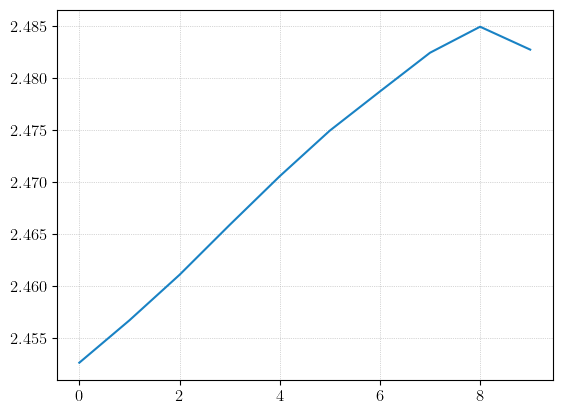

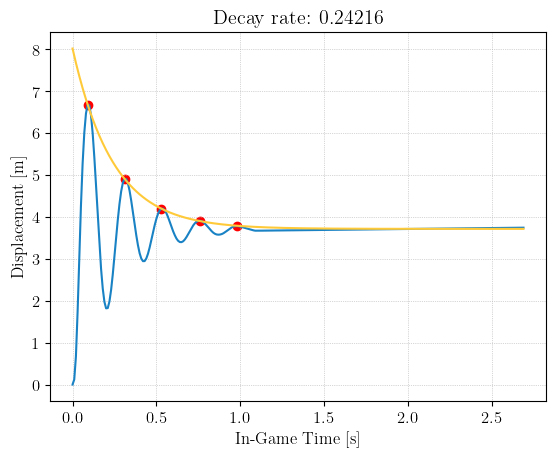

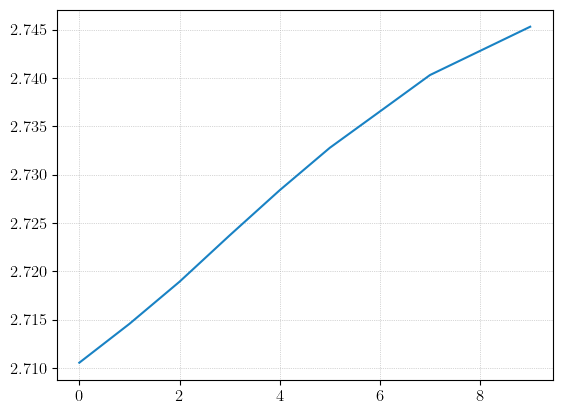

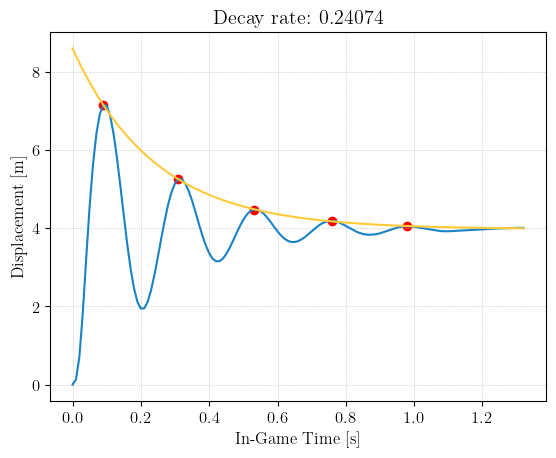

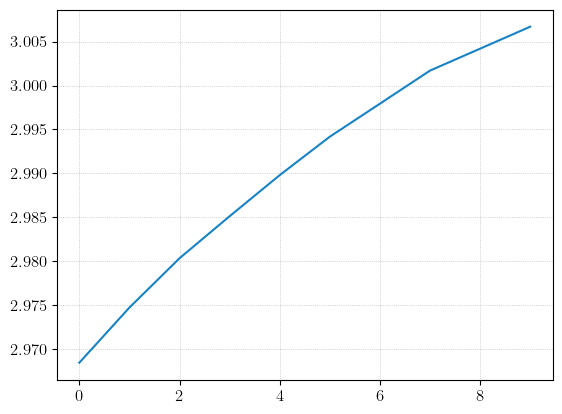

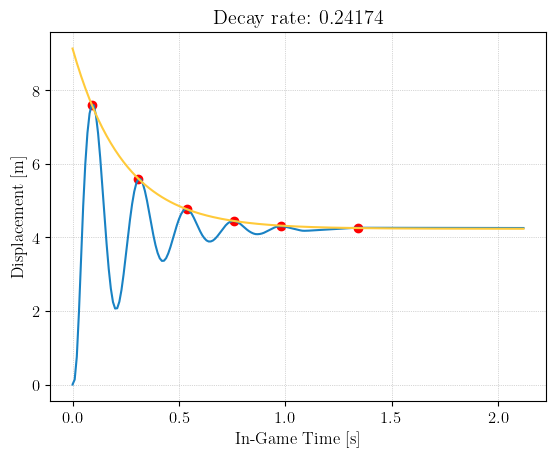

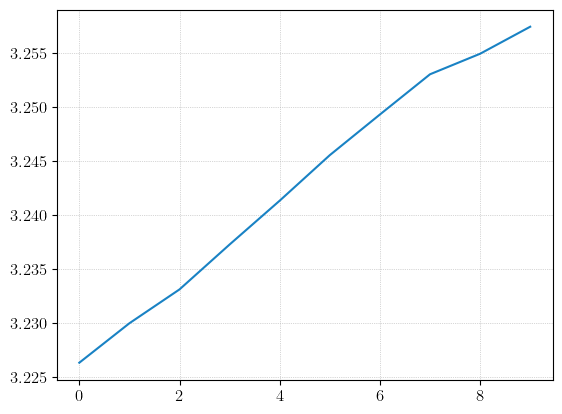

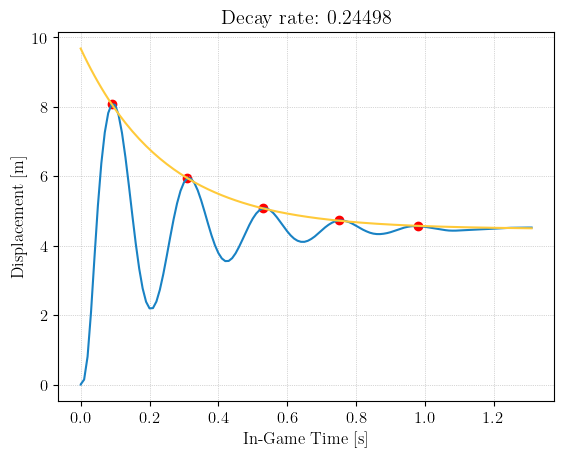

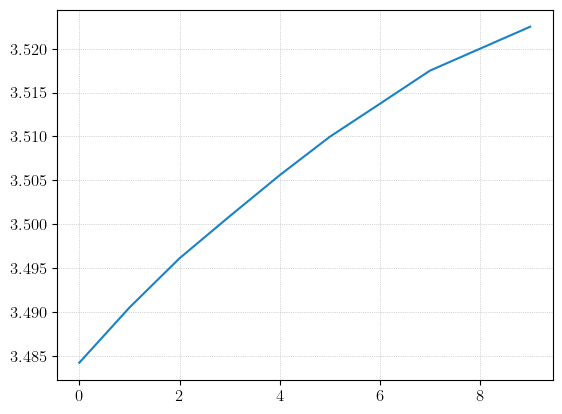

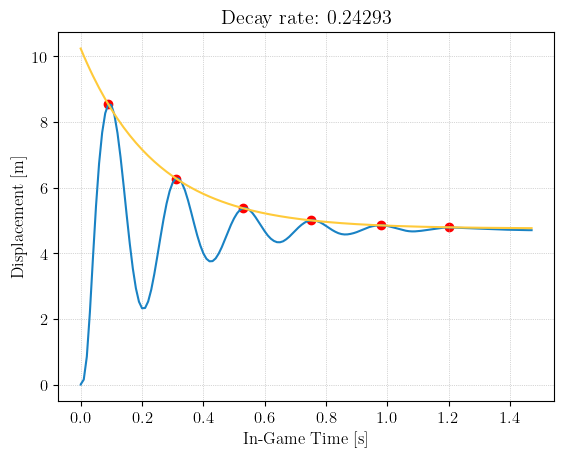

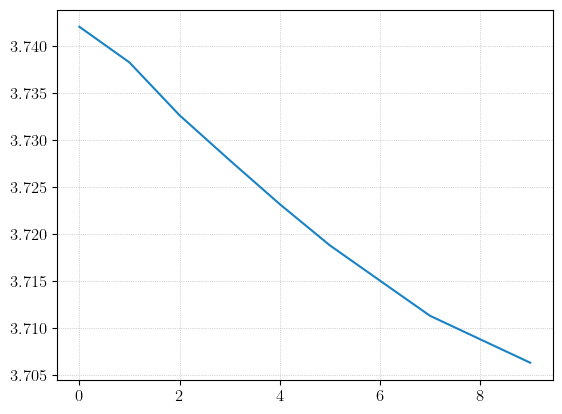

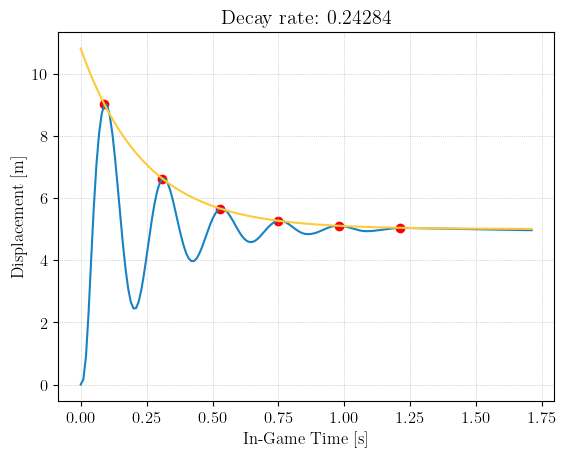

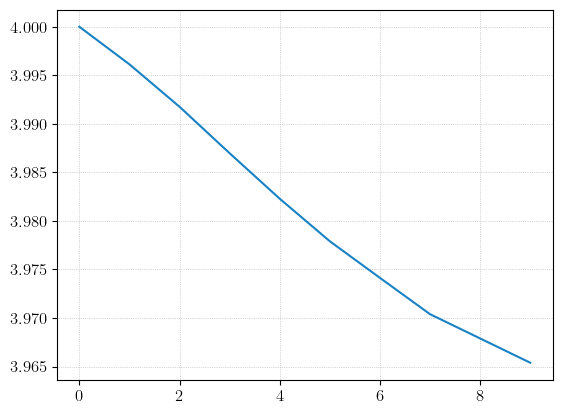

In [23]:

displacements = np.linspace(0.1,5, 20)[3:]

relaxation_times, offsets, loop_times, errors, params = get_all_data("displacemen", displacements, debug=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


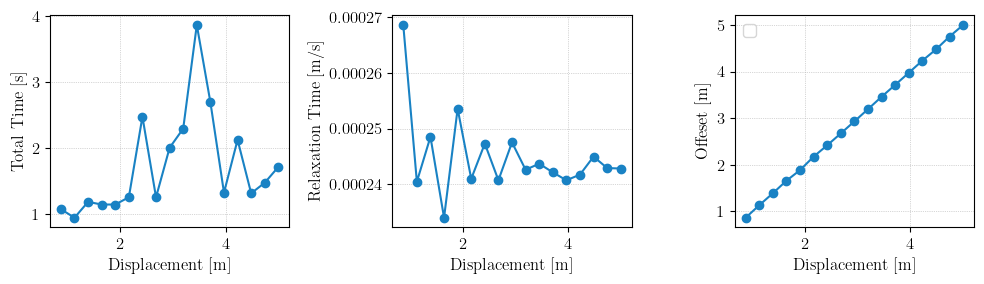

In [24]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

ax[0].plot(displacements, loop_times[0], "o-")
ax[0].set_xlabel("Displacement [m]")
ax[0].set_ylabel("Total Time [s]")

ax[1].plot(displacements, relaxation_times[0]/1000, "o-")
ax[1].set_xlabel("Displacement [m]")
ax[1].set_ylabel("Relaxation Time [m/s]")
#ax[1].set_yscale("log")
#ax[1].set_ylim(1e-4, 1e-2)

ax[2].plot(displacements, offsets[0], "o-")
ax[2].set_xlabel("Displacement [m]")
ax[2].set_ylabel("Offeset [m]")
#ax[2].set_yscale("log")
#ax[2].hlines(1,100,1000, color="darkgray", linestyle="--", label="Expected Offset")
#ax[2].set_ylim(0.1,1.1)
ax[2].legend()

plt.tight_layout()

plt.savefig("/home/max/Nextcloud/Praktikum/Results/displacements.png", dpi=300, bbox_inches="tight")
plt.show()

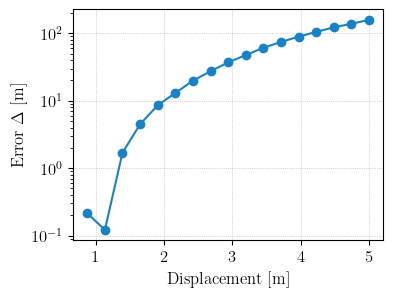

In [25]:
plot_data(displacements, errors[0], "Displacement [m]", "Error $\Delta$ [m]")
plt.yscale("log")
plt.savefig("/home/max/Nextcloud/Praktikum/Results/displacements_error.png", dpi=300, bbox_inches="tight")
plt.show()

# Transversal

In [82]:
PATH = "/home/max/Temp/Praktikum/experiments-transversal/"

In [109]:
positions = read_json_file("/home/max/Temp/Praktikum/experiments-transversal/constraint_solver_steps_1/constraint_solver_steps_1_500/positions.json")

experiment1 = GuidewireExperiment(positions)

Text(0.5, 1.0, 'Relaxation Time: 3.50569')

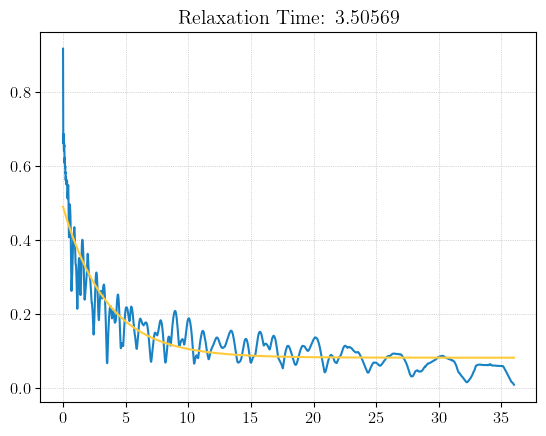

: 

In [110]:
delta = experiment1.get_delta()
time = experiment1.get_elapsed_time()/1000

plt.plot(time, delta)

def func(x, a, b,c):
    return a*np.exp(-x/b)+c

popt, pcov = curve_fit(func, time, delta, p0=[2, 10,0])

plt.plot(time, func(time, *popt))
#plt.yscale("log")
plt.title(f"Relaxation Time: {popt[1]:.5f}")